In [1]:
# import the libraries as shown below

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'xray_dataset_covid19/train'
valid_path = 'xray_dataset_covid19/test'


In [3]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [4]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [5]:

# useful for getting number of output classes
folders = glob('xray_dataset_covid19/train/*')

In [6]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

In [7]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [8]:
# view the structure of the model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [9]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [10]:
# Use the Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('xray_dataset_covid19/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 222 images belonging to 3 classes.


In [12]:
test_set = test_datagen.flow_from_directory('xray_dataset_covid19/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 60 images belonging to 3 classes.


In [14]:

# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=4,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/4
7/7 [==============================] - 72s 10s/step - loss: 0.1208 - accuracy: 0.9640 - val_loss: 0.2300 - val_accuracy: 0.9167
Epoch 2/4
7/7 [==============================] - 79s 11s/step - loss: 0.1321 - accuracy: 0.9550 - val_loss: 0.2352 - val_accuracy: 0.8833
Epoch 3/4
7/7 [==============================] - 85s 12s/step - loss: 0.1080 - accuracy: 0.9640 - val_loss: 0.2447 - val_accuracy: 0.9333
Epoch 4/4
7/7 [==============================] - 77s 11s/step - loss: 0.1230 - accuracy: 0.9685 - val_loss: 0.2036 - val_accuracy: 0.9333


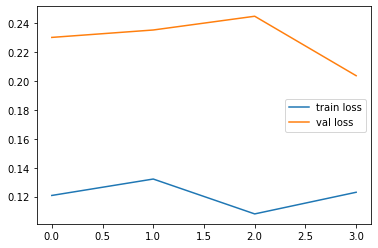

In [15]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')


In [16]:
# save it as a h5 file

import tensorflow as tf

from keras.models import load_model

model.save('model_vgg16_pnemo_covid.h5')